<a href="https://colab.research.google.com/github/ekourkchi/Weather_research/blob/master/MODWT_GPR_PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Installing extra packages on the current session
I use "george packages for the Gaussian Process analysis
Please visit here for further details: https://george.readthedocs.io/en/latest/user/kernels/


In [1]:
!pip install george


# Importing packages


In [2]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import george
from george import kernels
import pandas as pd
from datetime import datetime
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Load data
data preparation
We generate the first 3 main principal components that capture the most useful information of the data. P1, P2 and P3 are not correalted with each other while they are epressed as the linear cominination of the available featurdes, i.e. ET0, VPD, Rn and T (air temperature)

**Note:** Make sure that the data file is addressed correctly and it's already avaialble in your Google drive.

In [3]:

dataFile = 'Changde.xlsx'  
# dataFile = 'Hailisu.xlsx'  
# dataFile = 'Lancang.xlsx'  
# dataFile = 'Miyun.xlsx'  
# dataFile = 'Nanmulin.xlsx'  
# dataFile = 'Qiemo.xlsx'

data = pd.read_excel('/content/drive/My Drive/'+ dataFile)

In [4]:
# revising the column names
for col in data.columns:
  newcol = col.split("(")[0].strip()
  data.rename(columns={col:newcol}, inplace=True)

# setting up the index of the data frame
data.set_index("TIMESTAMP", inplace=True)

# resample data daily, forward linear interpolation to fill the missing values
data.resample('1d').mean()
data = data.interpolate(method='linear', limit_direction='forward', axis=0)

# displaying the first couple rows of the data table
data.head()

,DOY,U,T,ea（hpa）,RH,TA_min,TA_max,Rn,VPD,Delta,gamma,ET0
TIMESTAMP,,,,,,,,,,,,
1990-01-01,1.0,0.5,6.5,8.2,86.0,3.5,10.7,3.917056,0.133488,0.066737,0.067364,0.832234
1990-01-02,2.0,2.8,5.7,6.9,76.0,4.5,7.6,3.304720,0.217895,0.063561,0.067364,1.119791
1990-01-03,3.0,1.0,6.1,6.9,74.0,4.5,8.2,3.388471,0.242432,0.065133,0.067364,0.918324
1990-01-04,4.0,0.3,6.3,8.1,85.0,3.2,8.3,3.358427,0.142941,0.065931,0.067364,0.710937
1990-01-05,5.0,1.0,8.0,8.9,84.0,3.4,12.2,4.420837,0.169524,0.073061,0.067364,1.030776


In [5]:
import pywt
from modwt import modwt, modwtmra



def MODWT(data, features=None, paramName='ET0', n_level=3, n_details=3, waveletname = 'db4'):

  if n_details>n_level:
    print("Warning: n_details must be equal or smaller than n_level.")
    print("Warning: No action was taken.")
    return features;

  n_take = len(data)
  SharpData = data[paramName].values

  if features is None:
    features = data[[paramName]]
  
  wt = modwt(SharpData, waveletname, n_level)
  
  features[paramName+"_Wa"+str(n_level)] = wt[n_level,:]

  for i in range(n_level-1, (n_level-n_details), -1): 
    features[paramName+"_Wd"+str(i)] = wt[i,:]

  return features

def DWT(data, features=None, paramName='ET0', n_level=3, n_details=3, waveletname = 'db4'):

  if n_details>n_level:
    print("Warning: n_details must be equal or smaller than n_level.")
    print("Warning: No action was taken.")
    return features;

  n_take = len(data)
  SharpData = data[paramName].values

  if features is None:
    features = data[[paramName]]

  temp = pywt.downcoef('a', SharpData, waveletname, level=n_level)
  features[paramName+"_Wa"+str(n_level)] = pywt.upcoef('a', temp, waveletname, level=n_level, take=n_take)

  for i in range(n_level, (n_level-n_details), -1): 
    temp = pywt.downcoef('d', SharpData, waveletname, level=i)
    features[paramName+"_Wd"+str(i)] = pywt.upcoef('d', temp, waveletname, level=i, take=n_take)

  return features

def ADD(data, features=None, paramName='ET0'):

  if features is None:
    features = data[[paramName]]
  else:
    features[paramName] = data[paramName]

  return features

In [6]:

features = MODWT(data, paramName='ET0', n_level=5, n_details=5, waveletname = 'db8')
# features = DWT(data, features=features, paramName='Rn', n_level=2, n_details=1)
# features = DWT(data, features=features, paramName='Tc', n_level=2, n_details=1)
# features = ADD(data, features=features, paramName='VPD')
features.tail()

train_ends = "2016-12-31"
test_start = "2017"


# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

n_particles = 10
n_iter = 10

n_lag = 10
n_ahead = 1

target = 'ET0'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Staging some data for ML modeling


Generating train and test data sets.
For the sake of speed, we use use a fraction of data for evaluation of our algorithm. Later to get the final results, we use the entire data set.

Text(0.5, 0, 'Time')

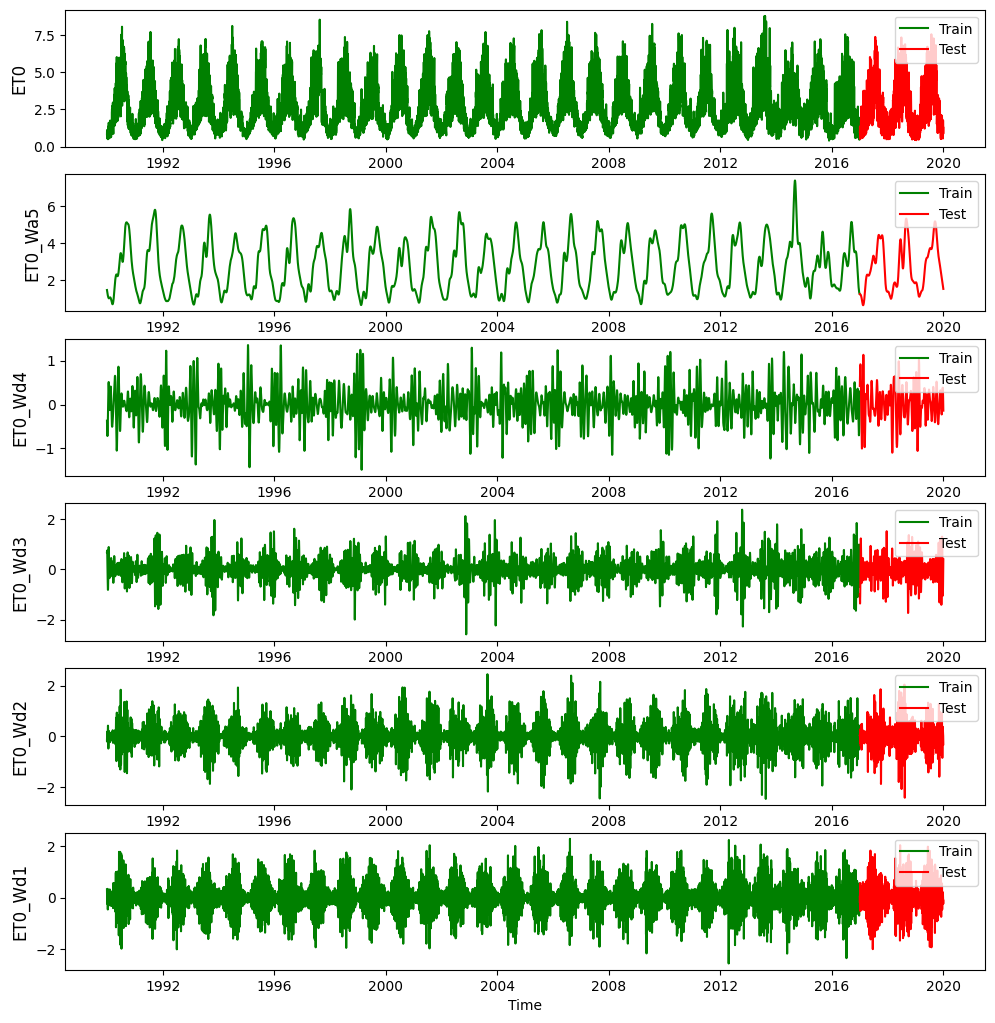

In [7]:
def plotFeature(df, column, ax, color='green', label=''):
  x = df.index
  y = df[column]
  ax.plot(x, y, color=color, label=label)  
  ax.set_ylabel(column, fontsize=12)
  


n_plots = len(features.columns)
fig = py.figure(figsize=(10,n_plots*2), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(n_plots,1) ; p=0


for p, column in enumerate(features.columns):

  ax = plt.subplot(gs[p]) ; p+=1
  plotFeature(features.loc[:train_ends], column, ax, color='green', label='Train')
  plotFeature(features.loc[test_start:], column, ax, color='red', label='Test')
  ax.legend(loc=1)



ax.set_xlabel("Time")

In [8]:
def metrics(y1, y2):
  '''
  y1 and y2 are two series of the same size

  This function outputs the MAE, RMSE and R^2 
  of the cross evaluated series.

  '''
  y1 = y1.reshape(-1)
  y2 = y2.reshape(-1)
  RMSE = np.sqrt(np.mean((y1-y2)**2))
  MAE = np.mean(np.abs(y1-y2))
  R2 = r2_score(y1, y2)
  print('MAE: %.2f'%MAE, ' RMSE: %.2f'%RMSE, ' R^2: %.2f'%R2)
########################################

def funcMAX(func, X, y, addParam = 0, maxiter=500, method='L-BFGS-B', verbose=False):
  
  '''
  A function to find the optimum parameters of the input funtion "func",
  where yp = func(X) and RMSE(y-yp) is minimzed

  output: "results" is the object that contains everything about the fit
  result.x holds the optimized parameters
  '''

  t1 =  datetime.now()  # t1 and t2 are used for timing this process
  ###########################################
  n = X.shape[1]
  # Maximum Likelihood
  Param_init = np.random.rand(n+addParam)
  result = minimize(func(X, y), Param_init, 
                method=method, options={"maxiter":maxiter})
  print("--------------------")
  if verbose:
    print(result)
  ###########################################
  if not verbose: 
    print("Fit Success: ", result.success)
  t2 =  datetime.now()
  print("Execution time: ", t2-t1)
  print("--------------------")

  return result

In [9]:
def dataPrepare2(df, n_lag=3, n_ahead=1, target='ET0', include_target=False):

  if not target in df.columns:
    print("Target is not available in the data frame.")
    return

  y = df[target].values
  N = len(y)
  dd = n_ahead - 1
  n = n_lag


  params = df.columns

  if not include_target:
    params = []
    for col in df.columns:
      if col!=target:
        params.append(col)

  n_params = len(params)

  XS = np.zeros((N-n-dd, n_params*n))
  ys = np.zeros(N-n-dd)

  p = 0 

  for i in range(0, N-n-dd):
    if not np.isnan(y[i+n+dd]):
      goodData = True
      for j, param in enumerate(params):
        z = df[param].values
        if not np.isnan(z[i:i+n]).any():
          XS[p,n*j:n*(j+1)] = z[i:i+n]     
        else:
          goodData = False
          break

      if goodData:
        ys[p] = y[i+n+dd]
        p+=1

  return XS[:p,:], ys[:p]

In [10]:
XS, ys = dataPrepare2(features["2010":train_ends], n_lag=n_lag, n_ahead=n_ahead, target=target, include_target=False)
XS_test, ys_test = dataPrepare2(features[test_start:], n_lag=n_lag, n_ahead=n_ahead, target=target, include_target=False)


n_components = XS.shape[1]
n_components

50

In [11]:
from sklearn.model_selection import train_test_split

def GPR(X, y, lnlikelihood=True):
  '''
  The output of this function is another function, either the lnlikelihood, or 
  the gp (the gaussian process regressor that is dfined by giving theta)
  '''
  n = X.shape[1]
    
  def step(theta):

        L = np.exp(theta[:n])
        sigma = np.exp(theta[n])   
        yerr = np.exp(theta[n+1])
        
        kernel = sigma * kernels.ExpSquaredKernel(np.ones(n), ndim=n)

        gp = george.GP(kernel)

        if lnlikelihood:
          gp = george.GP(kernel)
          gp.compute(X / np.vstack([L]*X.shape[0]), yerr)
       
          return -gp.lnlikelihood(y)
        else:
          X0 = X / np.vstack([L]*X.shape[0])
          gp.compute(X0, yerr)
          return gp
      
  return step

# PSO with PySwarm
Optimizing the GPR hyperparameters using the Particle Swarm Optimizer

https://pyswarms.readthedocs.io/en/latest/index.html

In [12]:
!pip install pyswarms

In [13]:
# Import modules
import numpy as np
from pyswarms.single.global_best import GlobalBestPSO
# Import PySwarms
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [14]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3)
kf.get_n_splits(XS)

def Xi2_swarm(x):
  
  nParticle = x.shape[0]
  out = np.zeros(nParticle)

  for train_index, cross_index in kf.split(XS):
    
      X_train, X_cross = XS[train_index], XS[cross_index]
      y_train, y_cross = ys[train_index], ys[cross_index]

      n = X_cross.shape[1]
      m = X_cross.shape[0]

      for n_iter in range(nParticle):
          
          theta = x[n_iter,:]

          L = np.exp(theta[:n])

          gp = GPR(X_train, y_train, lnlikelihood=False)(theta)
          gp_yp_cross, gp_yp_cross_std = gp.predict(y_train, X_cross/np.vstack([L]*m), return_var=True)

          out[n_iter] += np.sum((y_cross - gp_yp_cross)**2)

  return out


In [15]:
# Call instance of PSO
optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_components+2, options=options)

# Perform optimization
cost, pos = optimizer.optimize(Xi2_swarm, iters=n_iter)

2020-12-15 06:27:19,837 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=5.69e+3
2020-12-15 06:31:09,831 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5692.843009109489, best pos: [4.52099183 4.75106674 4.06714546 3.12603904 4.41907942 3.18911043
 2.4288547  3.11265514 2.99310896 2.38567218 4.77972566 3.77649237
 1.84314042 4.89401303 0.96983373 2.25988744 4.83113221 2.97065896
 5.10208888 4.74401192 3.58746697 4.07055316 3.96299866 5.94072684
 3.00086818 3.57520729 3.06486215 3.48123725 2.71839057 4.37274815
 4.10163825 4.16729674 4.0764749  4.72986006 4.04386245 5.11889187
 4.53990098 1.50598849 3.02474979 3.29916913 4.95659879 2.85821336
 5.16555475 4.50420237 4.02069857 2.01759129 3.96306527 2.95752398
 3.11036962 2.53927523 5.28797259 1.48961031]


In [16]:
pos

array([4.52099183, 4.75106674, 4.06714546, 3.12603904, 4.41907942,
       3.18911043, 2.4288547 , 3.11265514, 2.99310896, 2.38567218,
       4.77972566, 3.77649237, 1.84314042, 4.89401303, 0.96983373,
       2.25988744, 4.83113221, 2.97065896, 5.10208888, 4.74401192,
       3.58746697, 4.07055316, 3.96299866, 5.94072684, 3.00086818,
       3.57520729, 3.06486215, 3.48123725, 2.71839057, 4.37274815,
       4.10163825, 4.16729674, 4.0764749 , 4.72986006, 4.04386245,
       5.11889187, 4.53990098, 1.50598849, 3.02474979, 3.29916913,
       4.95659879, 2.85821336, 5.16555475, 4.50420237, 4.02069857,
       2.01759129, 3.96306527, 2.95752398, 3.11036962, 2.53927523,
       5.28797259, 1.48961031])

In [17]:
truths = pos
gp = GPR(XS, ys, lnlikelihood=False)(truths)


n = XS.shape[1]
m_test = XS_test.shape[0]
m = XS.shape[0]

L = np.exp(truths[:n])


gp_yp, gp_yp_std = gp.predict(ys, XS/np.vstack([L]*m), return_var=True)

gp_yp_test, gp_yp_test_std = gp.predict(ys, XS_test/np.vstack([L]*m_test), return_var=True)

In [18]:
def gtzero(x):

  for i in range(len(x)):
    if x[i]<=0:
      x[i] = 0
  return x 
  
print("Training set: ")
metrics(ys, gtzero(gp_yp))
print("----------------------")
print("Test set: ")
metrics(ys_test, gtzero(gp_yp_test))


Training set: 
MAE: 1.11  RMSE: 1.40  R^2: 0.33
----------------------
Test set: 
MAE: 1.14  RMSE: 1.42  R^2: 0.31


Text(0.5, 1.0, '1 day ahead predictions (Test)')

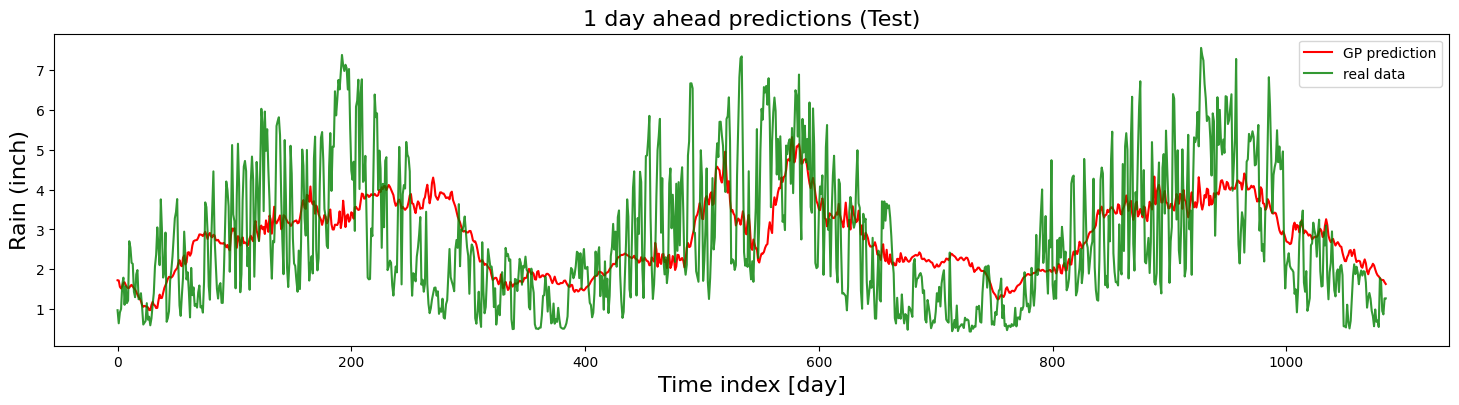

In [19]:
fig = py.figure(figsize=(15, 4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

# ax.plot(gp_yp, 'r.-',  alpha=1)
# ax.plot(ys2, 'g.-', alpha=0.8)

ax.plot(gtzero(gp_yp_test), 'r-',  alpha=1, label='GP prediction')
ax.plot(ys_test, 'g-', alpha=0.8, label='real data')

## Filling 
# ax.fill_between(range(len(gp_yp_test)), gp_yp_test - 1.*np.sqrt(gp_yp_test_std), gp_yp_test + 1.*np.sqrt(gp_yp_test_std),
#                 color="r", alpha=0.2)

ax.legend()
# ax.set_xlim(0,len(gp_yp_test))
ax.set_ylabel("Rain (inch)", fontsize=16)
ax.set_xlabel("Time index [day]", fontsize=16)
ax.set_title("1 day ahead predictions (Test)", fontsize=16)

NameError: ignored

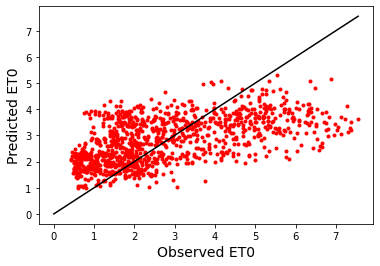

In [20]:
plt.plot(ys_test, gp_yp_test, 'r.')

max = np.max([np.max(ys_test), np.max(gp_yp_test)])
plt.plot([0, max], [0, max], 'k-')

plt.xlabel("Observed ET0", fontsize=14)
plt.ylabel("Predicted ET0", fontsize=14)

# plt.xlim(0,8)
# plt.ylim(0,8)
plt.title(station+'  ('+timezone+')', fontsize=16)

In [ ]:
N = len(ys_test)
metrics(ys_test[:N-1], ys_test[1:])